<a href="https://colab.research.google.com/github/bearylogical/bayesian_mm/blob/main/notebooks/emcee_strain_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

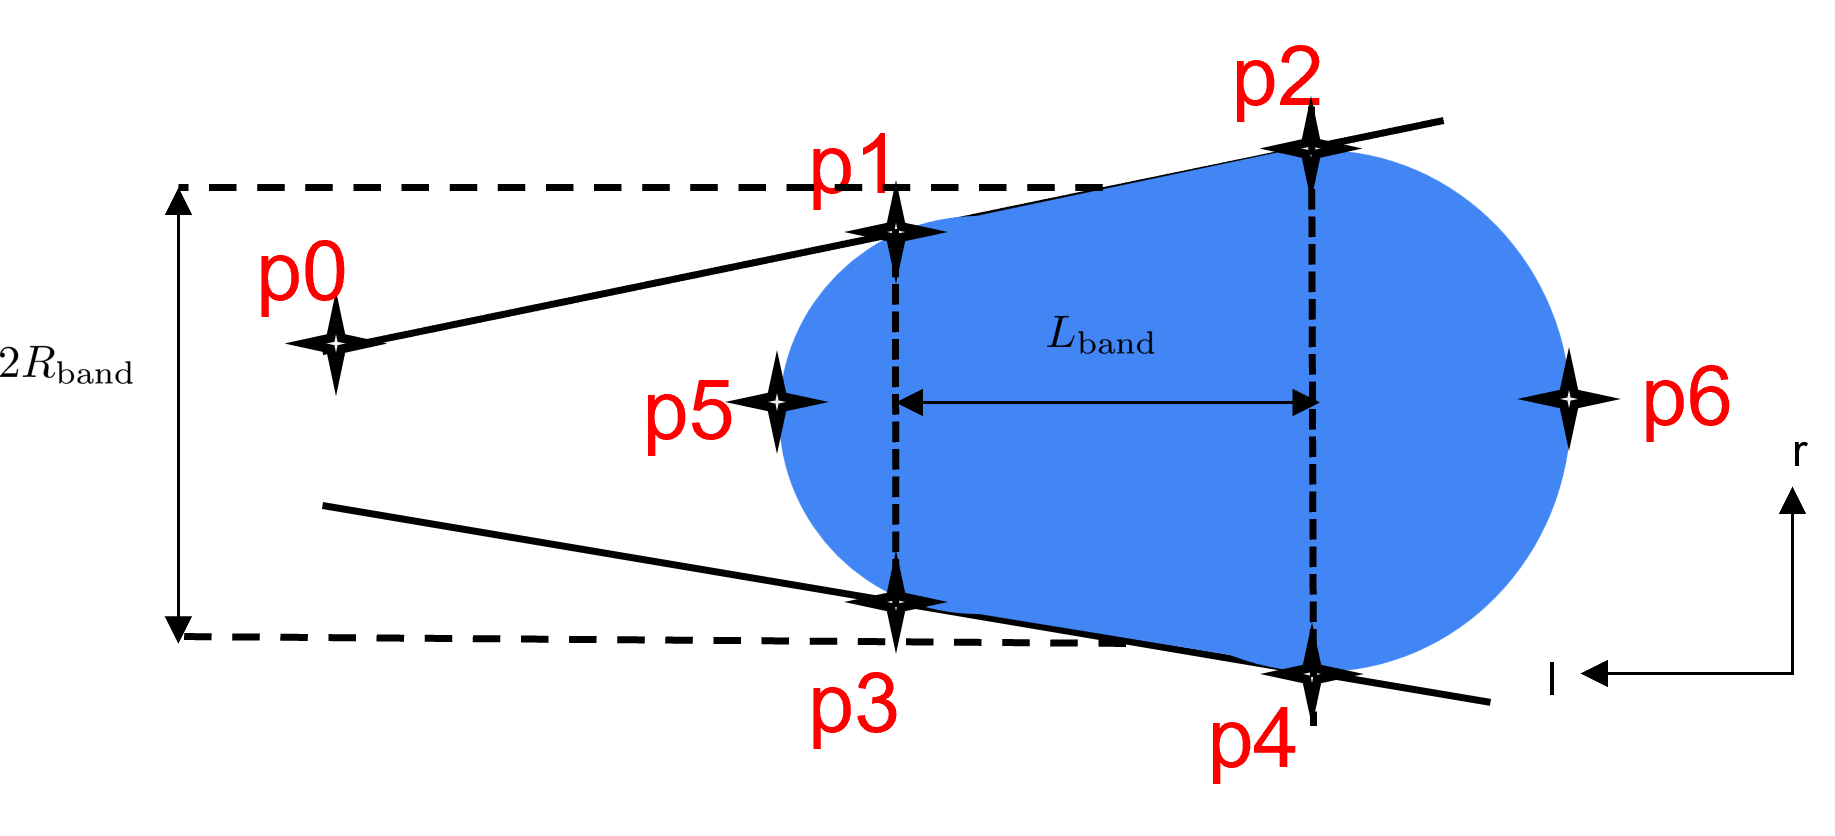# Material estimation using bayesian parameter estimation

Note: *Referenced from Nick Jaensson's tutorial on Bayesian Inference, along with all the conventions specified in the tutorial.* 

In this notebook, we will utilise the findings by Wyss et al. (2010) to obtain the Shear ($G$) and Elastic ($K$) modulus from observations of data of a trapped particle in a capillary under applied pressure. The situation is illustrated in the image below where we see that, due to the applied pressure, the particle moves to the left and is deformed in some directions.

<p style="text-align:center;"><img src="../assets/img_a.png" width="200" height="100"></p>

If we simplify the images above, we can get something like below:

<p style="text-align:center;"><img src="../assets/pre_post.png" width="600" height="400"></p>

From the above image, we take image (**A**) to be the reference image. With the application of pressure and some settling time for the particle to remain in its state under the applied pressure, we observe something similar to image (**B**).

To obtain the extent of deformation of the particle, we obtain keypoints from each image. Each experiment consists of a series of images taken at various applied pressures. The keypoints are provided below:

<p style="text-align:center;"><img src="../assets/ref_coords.png" width="600" height="400"></p>

With this information, we can obtain the characteristic dimension $L_\mathrm{band}$ and $R_\mathrm{band}$ throught the various points, *P*.  $L_\mathrm{band}$ the longitudinal length of the portion of the particle in contact with the walls of the capillary while $R_\mathrm{band}$ is the averaged radii of the front and back part of the particle (viewed as a conical frustum with half spheres at both ends)

By having more observations of the R and L bands, we get information on the deformation and, if we assume that the particle deforms isotropically (uniform in all directions), Wyss et al. obtained the following relations for $G$ and $K$.

$$ G = \frac{p_{\mathrm{wall}} - p}{2(\epsilon_r - \epsilon_z)} $$
$$ K = \frac{p_{\mathrm{avg}}}{2\epsilon_r + \epsilon_z} $$

$\epsilon_r$ refers to the change in  $R_\mathrm{band}$ given by : $\epsilon_r = \frac{R_0 - R_n}{R_0}$ where $n$ refers to the subsequent observations after $R_0$ (the first observation). Likewise, $\epsilon_z$ refers to the change in $L_\mathrm{band}$ given by  $\epsilon_z = \frac{L_0 - L_n}{L_0}$. 

Ideally, we assume that we conduct our observations in a highly controlled environment such that we believe that the results that we obtain are close to the actual G and K of the material. However, we know that such a situation is highly unlikely and there can exist other sources of error that can distort the true value. To be able to incorporate such such uncertainties of our results, we can turn to Bayesian Inference (BI). In this case, we are not absolutely certain of the **G** and **K** we have obtained from our experiment. We can view the model parameters **G** and **K** as random variables with an underlying probability distribution function. Subsequently, as seen from the above equation, we also need $p_\mathrm{wall}$ to obtain the G and K, since we cannot actually observe the pressure on the wall. For our purpose also denote it as an uncertain model parameter, or as a factor because we know it is simply a multiple of $p_0$ since it is increased across the experiment steps - i.e. $p_{\mathrm{fraction}} = \frac{p_{\mathrm{wall}}}{p}$. The uncertain model parameters can be denoted by $\boldsymbol{m}$ such that:


$$\boldsymbol{m} = \begin{Bmatrix}
G \\
K \\
p_{\mathrm{fraction}}
\end{Bmatrix}$$

Our reference image from which we obtain the strains have its own uncertainty around its L and R bands, together with the applied pressure, $P_0$. For a start, we'll assume that we are very certain about them and hence denote them as deterministic model parameters. In practice, to obtain **m** we need to make observations, $\boldsymbol{d}$ of the L and R bands.

$$\boldsymbol{d} = \begin{Bmatrix}
L_\mathrm{band, i} \\
R_\mathrm{band, i} 
\end{Bmatrix}$$

where $i\gt0$

Next, we denote a forward operator $\boldsymbol{g}$ which relates the model parameters and the observables. 

$$\boldsymbol{d} = \boldsymbol{g}(\boldsymbol{m})$$

We will need to invert our $G$ and $K$ relationships in order to obtain our strains such that we end up with our observable R and L band. This will be our forward operator, $\boldsymbol{g}$.

As mentioned previously, our observations can also be corrupted by noise. Hence we can represent as follows:

$$\boldsymbol{y_i} = \boldsymbol{g_i}(\boldsymbol{m}) + \epsilon \quad \text{for } 1 \leq i \leq N$$ 

with $\boldsymbol{y_i}$ being our observed measurables (R and L band), $\boldsymbol{g_i}$ being our forward model including our deterministic parameters which vary depending on $i$ and $\boldsymbol{\epsilon}$ which we assume to be the total noise containing contributions from both the measure noise and the model that, as a starting point is known and additive.  

For this notebook, we will use the value of G and K from Wyss et al. (2010) which are 0.8 kPa and 4.5 kPa respectively.

We first start by importing libraries we will use for this exercise

# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats as stats
import corner
import emcee
import seaborn as sns
from copy import deepcopy
np.random.seed(123)
import os
from tqdm import tqdm

from mpl_toolkits import mplot3d
from IPython.display import display, Math
os.chdir('/home/syamil/masters')
from src.utils.shapes.capillary import get_outline
%matplotlib inline

# Define our constants and our ground truth

In [2]:
def normalise_bands(bands, img_size):
    if (len(bands) == 2) and (len(img_size)==2):
        l_band, r_band = bands
    else:
        raise Exception('Wrong length for bands')
        
    return l_band / img_size[0] , r_band / img_size[1]
    

In [3]:
length_scale = 1e5
# constants
true_G = 10024.9056 / length_scale

true_K = 60996.0301 / length_scale
cov=1
A = np.array([[1, -1], [2,  1]])
A_inv = np.linalg.inv(A)

p_0 = 11220 / length_scale
true_p_wall = 19946.5733 / length_scale
true_p_factor = true_p_wall / p_0 # shouldn't matter with increasing p

img_resolution = (2880, 2048) # (w, h)
r_0, l_0 = 117.9 , 313.0
alpha = 0.064
rr_1, ll_1 = 95.565 , 376.859
n_l0, n_r0 = normalise_bands((l_0, r_0), img_resolution)
n_ll_1, n_rr_1,  = normalise_bands((ll_1, rr_1), img_resolution)

In [4]:
true_p_factor

1.777769456327986

# Plot an observation for one particular applied pressure.

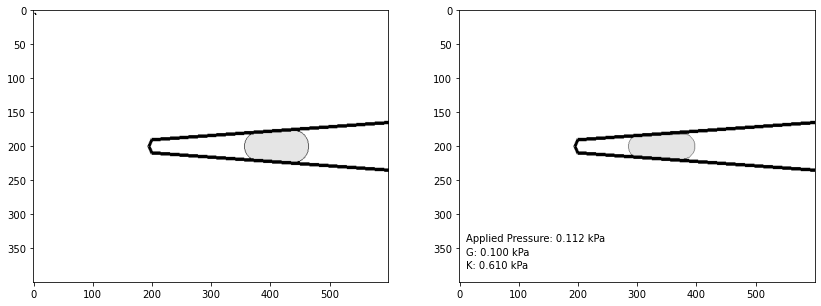

In [5]:
# visualize the l1, r1
from src.utils.shapes.capillary import CapillaryImage
from PIL import Image

initial = CapillaryImage(
        theta=alpha, l_band=n_l0, r_band=n_r0, img_size=(600, 400), taper_cutoff=200, is_deg=False, fill_alpha_outer=0
    )
initial_img =  Image.new(mode="L", size=initial.dim, color=255)
initial.generate_image(initial_img, is_annotate=False)
observed_cap = CapillaryImage(
        theta=alpha, l_band=n_ll_1, r_band=n_rr_1, img_size=(600, 400), taper_cutoff=200, is_deg=False)
obs_image = Image.new(mode="L", size=observed_cap.dim, color=255)
observed_cap.generate_image(obs_image, is_annotate=False)
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(14,5))
ax1.imshow(initial_img, cmap='gray', aspect='auto')
ax2.imshow(obs_image, cmap='gray', aspect='auto')
ax2.text(10, 340, f"Applied Pressure: {p_0:.3f} kPa")
ax2.text(10, 360, f"G: {true_G:.3f} kPa")
ax2.text(10, 380, f"K: {true_K:.3f} kPa")
ax1.arrow(2, 4, 2, 2, width = 0.05)
plt.show()

In [6]:
def plot_observations(initial_pos, observed_pos, noise_obs=None, alpha=alpha, figsize=(20, 6)):
    initial = CapillaryImage(
        theta=alpha, l_band=initial_pos[1], r_band=initial_pos[0], img_size=(600, 400), taper_cutoff=200, is_deg=False, fill_alpha_outer=0
    )
    initial_img =  Image.new(mode="L", size=initial.dim, color=255)
    initial.generate_image(initial_img, is_annotate=False)
    imgs = []
    imgs.append(initial_img)
    for pos in observed_pos:
        observed_cap = CapillaryImage(
            theta=alpha, l_band=pos[1], r_band=pos[0], img_size=(600, 400), taper_cutoff=200, is_deg=False)
        obs_image = Image.new(mode="L", size=observed_cap.dim, color=255)
        observed_cap.generate_image(obs_image, is_annotate=False)
        t_img = deepcopy(obs_image)
        imgs.append(t_img)
    
    if noise_obs is not None:
        noisy_obs_outline = [get_outline(noise_ob[1], noise_ob[0], initial) for noise_ob in noise_obs]
    
    nrow = len(imgs) // 3 if len(imgs) % 3 == 0 else len(imgs) // 3 + 1
    fig, axes = plt.subplots(ncols=3, nrows=nrow, figsize=figsize)
    for idx, img in enumerate(imgs):
        if idx == 0:
            seq_text = "Initial"
        else:
            seq_text = f"Sequence No. : {idx}"
        axes.flat[idx].text(10, 380, seq_text)
        axes.flat[idx].imshow(img, cmap='gray', aspect='auto')
        if noise_obs is not None and idx<len(noise_obs):
            axes.flat[idx+1].plot(noisy_obs_outline[idx][0], noisy_obs_outline[idx][1], alpha=0.5, color='red', label='Noise')
            axes.flat[idx+1].legend()
    plt.show()

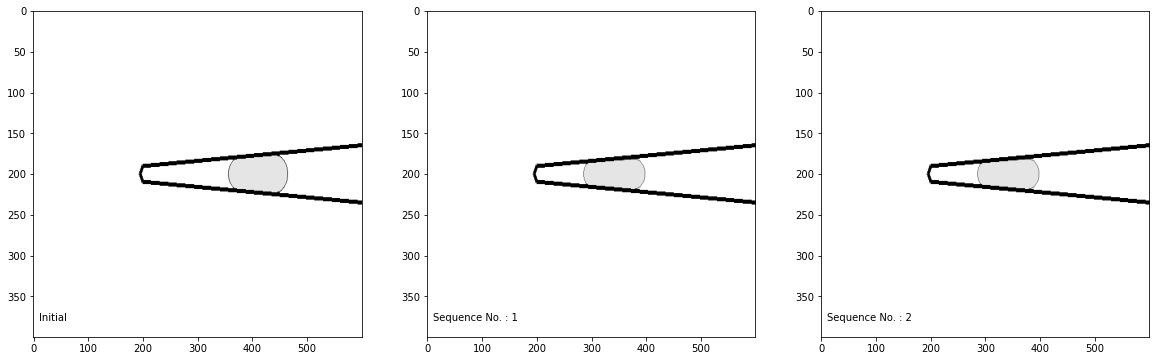

In [7]:
plot_observations([n_r0, n_l0], [[n_rr_1, n_ll_1], [n_rr_1, n_ll_1]])

## Defining our forward operator

Given a known G, K and $p_\mathrm{wall}$, we need to find a way to obtain our forward operator $\boldsymbol{g}$.

First we obtain our strains by solving $\epsilon_r$ and $\epsilon_z$ simultaneously:

$$ \begin{bmatrix}
\epsilon_r  \\
\epsilon_z
\end{bmatrix}
 = 
\begin{bmatrix}
1 & -1 \\
2 & 1 
\end{bmatrix}^{-1}
\begin{bmatrix}
\frac{\Delta P}{2 G} \\
\frac{P_\mathrm{avg}}{K}
\end{bmatrix}
$$

with $\Delta P = p_\mathrm{wall} - p_0$ and $P_\mathrm{avg}=\frac{1}{3}(2p_{\mathrm{wall}} + p_0) $

then, with we obtain $L_i$ and $R_i$ by the following: 

$$L_i = L_0 - \epsilon_z L_0 \\ 
  R_i = R_0 - \epsilon_z R_0 $$


In [8]:
# def p_wall(r, l, alpha, p):
#   return (p * (r + 0.5 * l * np.tan(alpha)) ** 2 ) / ( 2 * np.sin(alpha) * r * l * np.sqrt(1+ (np.tan(alpha))**2)) 

def model(G, K, p_factor, r_0=n_r0, l_0=n_l0, p_0=p_0):
    rl_0 = np.array([r_0, l_0]).T
    p_wall = p_factor * p_0 
    delta_P = p_wall - p_0
    p_avg =  1/3 * (2 * p_wall + p_0)
    b1 = delta_P / (2 * G )
    b2 = p_avg / (K)
    b = np.array([b1, b2])
    eps = A_inv.dot(b)  # [er, ez]
    return rl_0 - eps.T * rl_0

In [9]:
def decompose_l_r_band(theta, l_band, r_band) -> tuple:
    """
    Internal function to decompose the l and r band to get
    r_a and r_b, l_d and L and l_a respectively

    :return: Tuple of (v1_c1, r_a, r_b)
    """
    if r_band is None:
        raise GeometryError("No r_band specified")
    # if self.theta is None: # in subsequent images, we find that theta is fixed.
    #     self.theta = get_theta(l_band=self.l_band, r_band=self.r_band)
    l_d = r_band / np.tan(theta)

    del_r = l_band * np.tan(theta)
    r_a =  r_band - 0.5 * del_r
    r_b = r_a + 0.5 * del_r
    v1_c1 = r_a / np.tan(theta)

    return l_d, v1_c1, r_a, r_b

def inverse_model(r_0, l_0 , p_0, theta, r_1, l_1, p_factor):
    # l_d, v1_c1, r_a, r_b = decompose_l_r_band(theta, l_1, r_1)
    # f_p = p_0 * (np.pi * (r_b ** 2))  # force onto back portion of particle by pressure
    # f_wall = f_p / np.sin(theta)
    # a_band = np.pi * (r_b + r_a) * l_d
    # p_wall = f_wall / a_band
    p_wall = p_0 * p_factor
    eps_r = (r_0 - r_1) / r_0
    eps_z = (l_0 - l_1) / l_0

    G = (p_wall - p_0) / (2*(eps_r - eps_z))
    K = ((2 * p_wall + p_0) / 3) / (2 * eps_r + eps_z)
    return G, K 

In [10]:
true_G, true_K, true_p_factor

(0.100249056, 0.609960301, 1.777769456327986)

## Test our model function

In [11]:
temp_rl = model(true_G, true_K, true_p_factor,  n_r0, n_l0, p_0)
temp_rl

array([0.04385616, 0.13009658])

In [12]:
inverse_model(n_r0, n_l0, p_0, alpha, temp_rl[0], temp_rl[1], true_p_factor)

(0.10024905599999998, 0.609960301)

## Generate our data

Lets generate some data to obtain some values of $R_{\mathrm{band}}, L_{\mathrm{band}}$ and we assume our joint noise $\epsilon$ is Gaussian with a mean of zero and standard deviation, $\sigma_{\mathrm{noise}}$ of 1 (and that is additive).

Since these data are jointly observed, we constract a covariance matrix $\Sigma$ in which we assume that our $L_1$ and $R_1$ are independent (uncorrelated) with a standard deviation of 1. Hence,

$$\Sigma = \begin{bmatrix}
\sigma_{\mathrm{noise}} & 0 \\
0 & \sigma_{\mathrm{noise}} 
\end{bmatrix} $$

In our dataset, we adopt the following scheme. Each _experiment_ is defined as a sequence of *N* Observations. Typically we have M experiments. Thus, in our dataset,  we should have a total of M * N observations.

In [124]:
N = 5

# Our applied pressures
pressures = np.linspace(1e3, 2e4, N) / length_scale
pressures = np.expand_dims(pressures, 1)

# Define our initial bands
initial_bands = np.expand_dims(np.array([n_r0, n_l0]),0)
initial_bands = np.repeat(initial_bands, N, axis=0)
x = np.append(initial_bands, pressures,axis=1)
y_true = model(true_G, true_K, true_p_factor , x[:,0], x[:,1], x[:,2])
# x_noise = x + np.array([1e-3, 1e-3, 1e2]).T * np.random.randn(3, N).T

In [125]:
M_experiments = 5

x_experiments = np.repeat(x, M_experiments, axis=0)
y_experiments = model(true_G, true_K, true_p_factor ,  x_experiments[:,0], x_experiments[:,1], x_experiments[:,2])
y_experiments = y_experiments +  np.array([1e-3, 1e-3]) * np.random.randn(2, N * M_experiments).T

In [129]:
y_noise = y_true +  np.array([1e-3, 1e-3]) * np.random.randn(2, N).T
_G, _K  = inverse_model(n_r0, n_l0, x[:,2], alpha, y_noise[:,0], y_noise[:,1], true_p_factor)

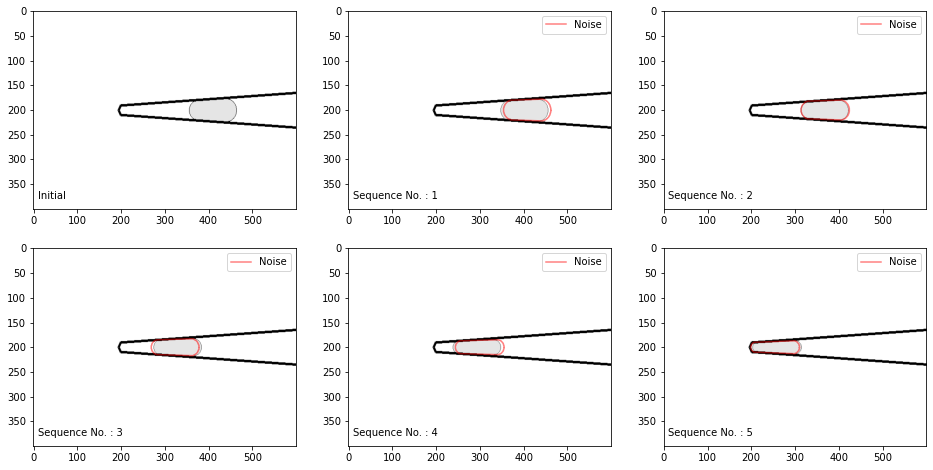

In [130]:
plot_observations([n_r0, n_l0], y_true, noise_obs=y_noise, figsize=(16, 8))

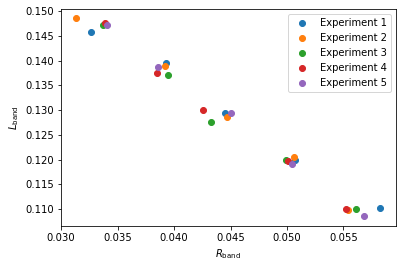

In [136]:
plt.xlabel(xlabel='$R_{\mathrm{band}}$') 
plt.ylabel('$L_{\mathrm{band}}$')
# for idx, (x_i, y_i) in enumerate(zip(y_experiments[:,0], y_experiments[:,1])):
#     plt.text(x_i, y_i+0.001, idx)
for exp in range(M_experiments):
    plt.scatter(y_experiments[exp::M_experiments,0], y_experiments[exp::M_experiments,1], color=plt.cm.tab10(exp), label=f'Experiment {exp + 1}')
plt.legend()
plt.show()

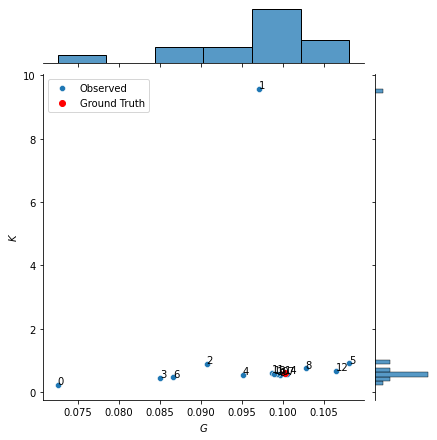

In [17]:
jp = sns.jointplot(x=_G, y=_K, label='Observed')
jp.set_axis_labels(xlabel='$G$', ylabel='$K$') 
for idx, (g, k) in enumerate(zip(_G, _K)):
    jp.ax_joint.text(g, k+0.01, idx)
jp.ax_joint.scatter(true_G, true_K, c='red', label='Ground Truth')
jp.ax_joint.legend()
plt.show()

## Bayesian Inference : Details

In this section, we will describe the Bayesian approach in greater detail.

Bayesian inference is an application of Bayes rule where:

$$P(\boldsymbol{m}\mid \boldsymbol{y}) = \frac{P(\boldsymbol{y}\mid \boldsymbol{m})P(\boldsymbol{m})}{P(\boldsymbol y)}$$

In this way, we can obtain the probability of our model parameters, $\boldsymbol{m}$ given some observations $\boldsymbol{y}$.

Note that for multiple observations of $\boldsymbol{y}_1, \boldsymbol{y}_2, \boldsymbol{y}_3, \dots, \boldsymbol{y}_N$ we denote those observations as $\boldsymbol{y}$ which is applicable to all terms containing $\boldsymbol{y}_1$ in the Bayes' formulation above.

We then use the following conventions to denote the terms of the Bayes' rule:

- $P(\boldsymbol{m}\mid \boldsymbol{y})$ : Posterior probability
- $P(\boldsymbol{y}\mid \boldsymbol{m})$ : Likelihood
- $P(\boldsymbol{m})$ : Prior - This is where we encode our knowledge of our materials i.e Values G and K can take. 
- $P(\boldsymbol y)$ : Evidence



# Define our Priors

What does it mean to "encode our knowledge?" Supposing that we have an inklking that G (for this batch of synthesized microgels) should be between 8kPa and 11kPa. To make this more concrete, we also know that from our previous experiments, the value of G is around 10kPa.

From this information, we know that at 10kPa, the probability that that value is close to the true value of G is the highest, with a standard deviation of 1kPa. This allows us to represent this bit if information as a Gaussian distribution as $G\sim N (10000, 1000)$ and formalised as:

$$ p(G) = \frac{1}{\sqrt{2\pi}\sigma_{\mathrm{prior}}} \exp \Big( -\frac{(G-\bar{G}_{\mathrm{prior}})^2}{2\sigma^2_{\mathrm{prior}}}\Big)$$

This is similar to our $K$ where we can denote this by $K\sim N(60000, 5000)$. Note that we are less certain on our K, thus we adjust our $\sigma_{K}$ accordingly.

As for the $p_{\mathrm{fraction}}$. we will represent this with a flat (uniform) prior where we assign equal probability to all the values within the range such that $0.1 \leq p_{\mathrm{fraction}} \leq 2$.

A flat prior is defined as: 

$$ p(x) = \begin{cases}
        \frac{1}{b-a} & for \quad x\in[a,b] \\
        0 & otherwise \\
    \end{cases}$$

We can illustrate the probability distribution of G like below:



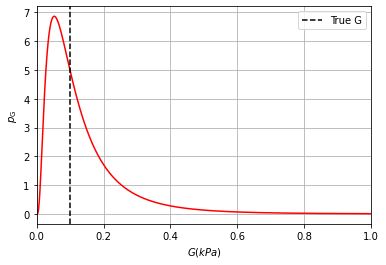

In [18]:
gplot = np.linspace(0, 1, 1000)
plt.plot(gplot,stats.lognorm.pdf(gplot,.8,loc=0, scale=.1),c='r')
plt.axvline(true_G, ls='--',c='black', label='True G')
plt.xlim([0, 1])
plt.xlabel("$G (kPa)$")
plt.ylabel("$p_{\mathrm{G}}$")
plt.grid()
plt.legend()
plt.show()

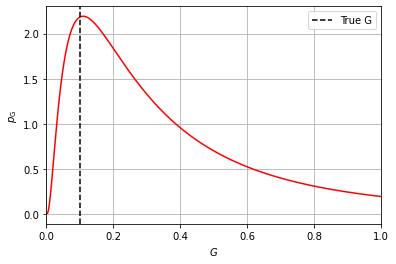

In [19]:
gplot = np.linspace(0, 1, 1000)

plt.plot(gplot,stats.lognorm.pdf(gplot, 1, loc=0, scale=.3),c='r')
plt.axvline(true_G, ls='--',c='black', label='True G')
plt.xlim([0, 1])
plt.xlabel("$G$")
plt.ylabel("$p_{\mathrm{G}}$")
plt.grid()
plt.legend()
plt.show()

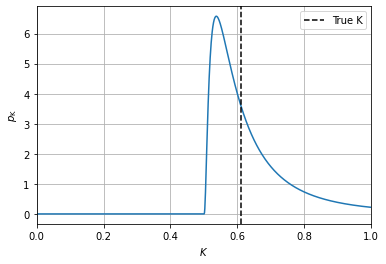

In [20]:
kplot = np.linspace(0, 1, 1000)

plt.plot(kplot,stats.lognorm.pdf(kplot,1,loc=0.5, scale=.1))
plt.axvline(true_K, ls='--',c='black', label='True K')
plt.xlim([0, 1])
plt.xlabel("$K$")
plt.ylabel("$p_{\mathrm{K}}$")
plt.grid()
plt.legend()
plt.show()

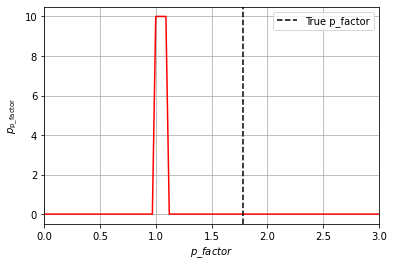

In [21]:

fp_plot = np.linspace(0, 3, 100)

plt.plot(fp_plot,stats.uniform.pdf(fp_plot,1, scale=.1),c='r')
plt.axvline(true_p_factor, ls='--',c='black', label='True p_factor')
plt.xlim([0, 3])
plt.xlabel("$p\_factor}$")
plt.ylabel("$p_{\mathrm{p\_factor}}$")
plt.grid()
plt.legend()
plt.show()

And we do something similar to show what our $p_{\mathrm{wall}}$ flat prior looks like.

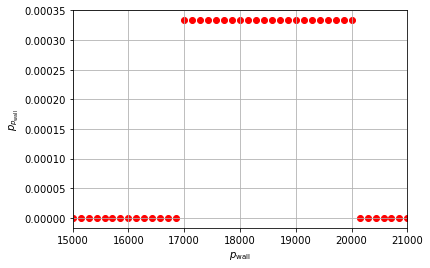

In [22]:
pwall_plot = np.linspace(1.5e4, 2.2e4, 50)

uniform_a = 1.7e4
uniform_b = 2e4
def uniform_prior(x, a, b):
    res = np.zeros(x.shape)
    res[(x<=b) & (x>=a)] = 1 / (b-a) 
    return res      

plt.scatter(pwall_plot,uniform_prior(pwall_plot,uniform_a,uniform_b),c='r') 
plt.xlim([1.5e4, 2.1e4])
plt.xlabel("$p_{\mathrm{wall}}$")
plt.ylabel("$p_{p_{\mathrm{wall}}}$")
plt.grid()
plt.show()

We encode all these priors as below. Note that we represent all our priors as log priors such that we can sum up the log of each prior probability for a given parameters' respective distribution. Note that the uniform prior overides all other priors as it is only 0 within the range while $-\infty$ otherwise, This means that anything summed with $-\infty$ is $-\infty$ ultimately.

In [137]:
def log_prior(theta):
    G, K, p_factor = theta

    p_G = stats.norm.logpdf(G, loc=.7, scale=.7)
    p_K = stats.norm.logpdf(K,loc=0.4, scale=.1)
    p_p = stats.uniform.logpdf(p_factor, loc=1.5, scale=1)

    return np.sum([p_G, p_K, p_p])


def log_prior_lognorm(theta):
    G, K, p_factor = theta

    p_G = stats.lognorm.logpdf(G,.8,loc=0, scale=.1)
    p_K = stats.lognorm.logpdf(K,1,loc=0.5, scale=.1)
    p_p = stats.lognorm.logpdf(p_factor, 1, loc=1.5, scale=.1)

    return np.sum([p_G, p_K, p_p])



# Define our likelihood

First, we define our likelihood $P(\boldsymbol{y}\mid \boldsymbol{m})$ using the multivariate likelihood as we obtain both values jointly. 

This is given by the expression:
$$p(\boldsymbol{X}\mid \boldsymbol{m}) = \prod_{n=1}^N p(x_n\mid\boldsymbol{m}) = \frac{N}{\sqrt{(2\pi)^k\det{\Sigma}}} \prod_{n=1}^N  \exp\Big({-\frac{1}{2}(x_i-\boldsymbol{g}_i({\boldsymbol{m}}))^T\Sigma^{-1}(x_i-\boldsymbol{g}_i({\boldsymbol{m}}))}\Big)$$



We use the log multivariate formulation and drop constant terms.

$$\ln L(y) = - \frac{1}{2}\Big[(y - \boldsymbol{g}(\boldsymbol{m}))^T \Sigma^{-1} (y- \boldsymbol{g}(\boldsymbol{m}))\Big]$$ 

$\Sigma$ is a $D \times D$ covariance matrix with $\sigma_{\mathrm{noise}}$ along its diagonals and uncorrelated, as defined at the start. For our situation, D=2. 

Let's try to visualize how this likelihood function works

In [138]:
def mv_likelihood(param, x, data, sigma):
    G, K, p_factor = param 
    r_0, l_0, p_0 = np.hsplit(x, 3)  # unpack our data
    y_pred = model(G, K, p_factor, r_0.flatten(), l_0.flatten(), p_0.flatten())
    return stats.multivariate_normal.logpdf(y_pred.T.flatten() * 100, data.T.flatten() * 100, sigma)

First, we define a parameter space

In [27]:
from itertools import product

g_params = np.linspace(.05, .2, 100)
k_params = np.linspace(.4, .8, 100)
f_pwall_params = [true_p_factor]

parameter_space=np.array(list(product(g_params, k_params, f_pwall_params)))

In [28]:
likelihoods = np.zeros(len(parameter_space))
for i in tqdm(range(len(parameter_space))):
    likelihoods[i] = mv_likelihood(parameter_space[i], x, y_noise, 1)


100%|██████████| 10000/10000 [00:01<00:00, 5274.23it/s]


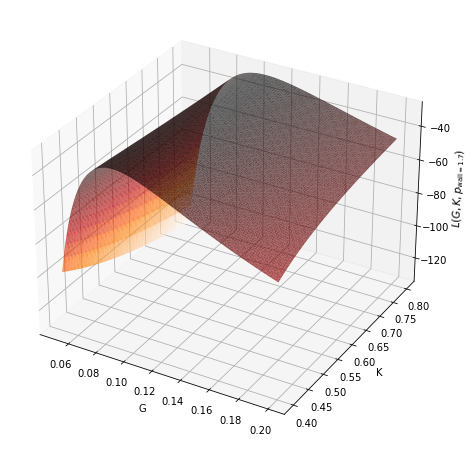

In [29]:

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')
G, K = parameter_space[:,0], parameter_space[:,1]
ax.plot_trisurf(G, K, likelihoods, cmap=plt.cm.gist_heat_r, alpha=0.7)

ax.set_xlabel('G')
ax.set_ylabel('K')
ax.set_zlabel('$L(G, K, p_{\mathrm{wall}=1.7})$');
plt.show()

In [30]:
def log_likelihood(theta, x, y_obs, cov):
    # return np.log(mv_likelihood(theta, x, y, cov))
    G, K, p_factor = theta 
    r_0, l_0, p_0 = [x.flatten() for x in np.hsplit(x, 3)]  # unpack our data
    y_pred = model(G, K, p_factor, r_0, l_0, p_0)
    return stats.multivariate_normal.logpdf(y_pred.T.flatten() * 100, y_obs.T.flatten()* 100, 1)
    # print(loglikelihood.sum())
    # return loglikelihood.sum()

# Obtain the MLE of the log likelihood

TODO : Explain what is the maximum likelihood estimate

In [31]:
# solve via MLE
from scipy.optimize import minimize

# x = np.array((n_r0, n_l0, p_0)) + 0.1 + np.random.randn(3, N).T
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([true_G, true_K, true_p_factor]) + 1e-3 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y_noise, cov))
G_ml, K_ml, p_wall_ml = soln.x

print("Maximum likelihood estimates:")
print(f"MLE G = {G_ml:.3f}, True G: {true_G:.3f}")
print(f"MLE K = {K_ml:.3f}, True K: {true_K:.3f}")
print(f"MLE p_wall_frac = {p_wall_ml:.3f}, True p_wall_frac = {true_p_factor:.3f}")

Maximum likelihood estimates:
MLE G = 0.100, True G: 0.100
MLE K = 0.599, True K: 0.610
MLE p_wall_frac = 1.780, True p_wall_frac = 1.778


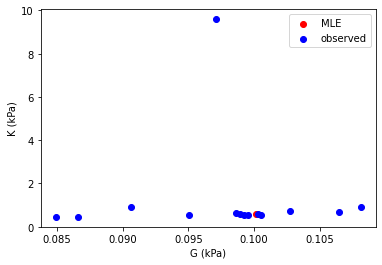

In [32]:
plt.scatter(x=G_ml, y=K_ml, c='red', label='MLE')
plt.scatter(x=_G[1:], y=_K[1:], c='blue', label='observed')
plt.xlabel('G (kPa)')
plt.ylabel('K (kPa)')
plt.legend()
plt.show()

In [33]:
# pred = model(G_ml, K_ml, p_wall_ml, n_r0, n_l0, p_0)
# plt.scatter(y[:,0], y[:,1])
# plt.scatter(x=pred[0], y=pred[1], c='red')

We see that the MLE value lies right in the middle of our points. Let's also put the MLE solution in our 3D plot 

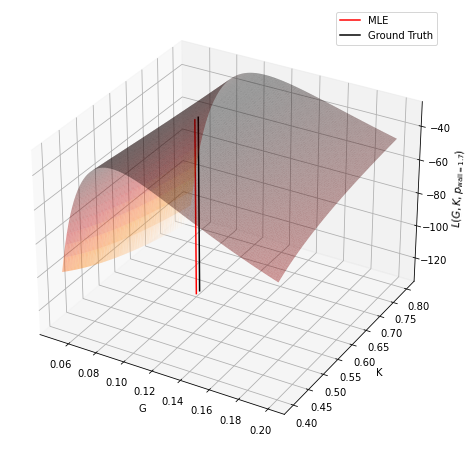

In [34]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')
G, K = parameter_space[:,0], parameter_space[:,1]
ax.plot_trisurf(G, K, likelihoods, cmap=plt.cm.gist_heat_r, alpha=0.4)

ax.plot([G_ml,G_ml], [K_ml, K_ml], [likelihoods.min(), likelihoods.max()], c='r', label='MLE')
ax.plot([true_G,true_G], [true_K, true_K], [likelihoods.min(), likelihoods.max()], c='black', label='Ground Truth')
ax.set_xlabel('G')
ax.set_ylabel('K')
ax.set_zlabel('$L(G, K, p_{\mathrm{wall}=1.7})$');
ax.legend()
plt.show()



# Define our posterior function


Our Posterior Probability is explicitly stated as:
$$ P(G, K \mid r_0, l_0, r_1, l_1, p) \propto P(r_1, l_1, G, K, p_{\mathrm{wall}})P(r_1, l_1 | G, K, r_0, l_0, \alpha, p, p_{\mathrm{wall}})$$

Because we are taking the log of the posterior, we can formulate the posterior as a sum of the (log) prior and the (log) likelihood.

In [35]:
def log_probability(theta, x, y, cov):
    lp = log_prior_lognorm(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, cov)

## Sampling



### Using Metropolis-Hastings method
1. Select an initial sample $x_0$
2. Define a proposal distribution $q$.
3. Draw a sample $x_p$ from $q$
4. We define an acceptance parameter, $u$ which is drawn from a uniform distribution
5. We calculate the ratio $r(x_i, x_p)$ defined as $\frac{p(x_p)q(x_i \mid x_p)}{p(x_i)q(x_p \mid x_i)}$
6. if $r(x_i, x_p) \ge u$, we set $x_{i+1} = x_p$ else $x_{i+1} = x_i$  

As stated by Rappel, the initial sample $x_0$ and the proposal distribution can greatly affect the efficiency of the sampling procedure. The most common proposal distribution is the gaussian distribution.

# Sampling
Use `emcee` to sample from our posterior

`emcee` needs somewhere to start. We use the MLE result as a starting point for the random walk. Note that emcee uses the affine sampler

In [36]:
from emcee.moves import GaussianMove

In [139]:
pos = soln.x + 1e-4 * np.random.randn(50, 3) # initialise our walker starting positions as a gaussian ball.
nwalkers, ndim = pos.shape 

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x_experiments, y_experiments, cov))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [04:22<00:00, 19.06it/s]


## Model Diagnostics

In this section we visualise the results of the sampling procedure to get some view of the stability of the chain samples.

In [38]:
import matplotlib.pyplot as plt

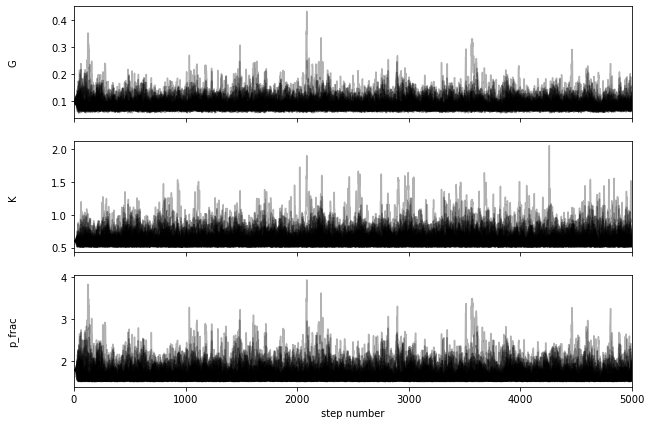

In [140]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["G", "K", "p_frac"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [141]:
acts = sampler.get_autocorr_time()
act_max = int(np.max(acts))
flat_samples = sampler.get_chain(discard=2 * act_max, thin=act_max // 2, flat=True)

In [142]:
# flat_samples = sampler.get_chain(discard=100, thin=25, flat=True)
# print(flat_samples.shape)

# Results

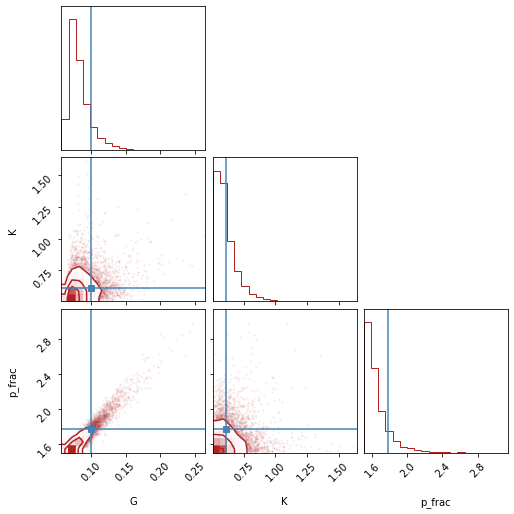

In [143]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[true_G, true_K, true_p_factor],
    color='firebrick'
);

In [144]:
# flat_samples = flat_samples[np.isclose(flat_samples[:,0], true_G, rtol=1e-1) & np.isclose(flat_samples[:,1], true_K, rtol=1e-1)]

(array([3.383e+03, 2.584e+03, 1.342e+03, 6.970e+02, 4.190e+02, 2.400e+02,
        1.230e+02, 9.800e+01, 5.500e+01, 4.700e+01, 1.700e+01, 1.800e+01,
        5.000e+00, 5.000e+00, 6.000e+00, 2.000e+00, 1.000e+00, 3.000e+00,
        2.000e+00, 2.000e+00]),
 array([1.5  , 1.575, 1.65 , 1.725, 1.8  , 1.875, 1.95 , 2.025, 2.1  ,
        2.175, 2.25 , 2.325, 2.4  , 2.475, 2.55 , 2.625, 2.7  , 2.775,
        2.85 , 2.925, 3.   ]),
 <BarContainer object of 20 artists>)

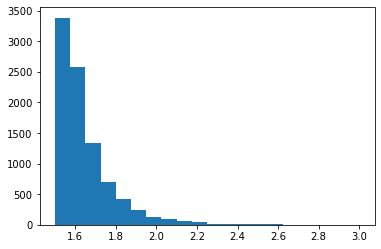

In [145]:
plt.hist(flat_samples[:,2], bins=20, range=(1.5, 3))

In [146]:
ndim=3
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

print("Maximum likelihood estimates:")
print(f"MLE G = {G_ml:.3f}, True G: {true_G:.3f}")
print(f"MLE K = {K_ml:.3f}, True K: {true_K:.3f}")
print(f"MLE p_wall_frac = {p_wall_ml:.3f}, True p_wall_frac = {true_p_factor:.3f}")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Maximum likelihood estimates:
MLE G = 0.100, True G: 0.100
MLE K = 0.599, True K: 0.610
MLE p_wall_frac = 1.780, True p_wall_frac = 1.778


In [46]:
q1 , m, q3 = np.percentile(flat_samples, [16, 50, 84], axis=0)

## Visualize our G and K's

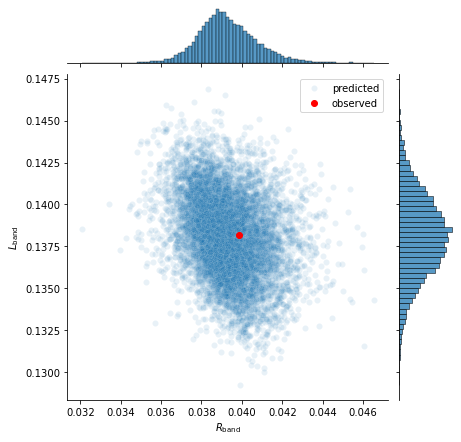

In [147]:
nr_idx = 3
_tx = x[nr_idx,:]
predicted_l_r_bands = np.array([model(*sample, *_tx) for sample in flat_samples])
lr_jp = sns.jointplot(x=predicted_l_r_bands[:,0], y=predicted_l_r_bands[:,1], label='predicted', alpha=0.1)
lr_jp.set_axis_labels(xlabel='$R_{\mathrm{band}}$', ylabel='$L_{\mathrm{band}}$') 
# for idx, (x_i, y_i) in enumerate(zip(predicted_l_r_bands[:,0], predicted_l_r_bands[:,1])):
#     lr_jp.ax_joint.text(x_i, y_i+0.001, idx)
lr_jp.ax_joint.scatter(y_noise[nr_idx,0], y_noise[nr_idx,1], c='red', label='observed')
lr_jp.ax_joint.legend()
plt.show()

## Plot the mean G, K and p_wall into the model

In [148]:
def plot_mean_shape(inputs, obs, flat_chain, figsize=(10,6), r_idx=1):
    plt.figure(figsize=figsize)

    observed_cap = CapillaryImage(
            theta=alpha, l_band=obs[r_idx,1], r_band=obs[r_idx,0], img_size=(600, 400), 
            taper_cutoff=200, is_deg=False, fill_alpha_inner=0.8, fill_alpha_outer=0,
        )
    temp_image = Image.new(mode="L", size=observed_cap.dim, color=255)
    observed_cap.generate_image(temp_image, is_annotate=False)
    _r1, _l1 = model(*flat_chain.mean(axis=0), *inputs[r_idx]) 
    _x_coords, _y_coords = get_outline(_l1, _r1, observed_cap)
    plt.plot(_x_coords, _y_coords, alpha=0.5, color='blue', label='Mean Predicted')

    plt.imshow(temp_image, cmap="gray", aspect="auto")
    plt.legend()
    plt.show()

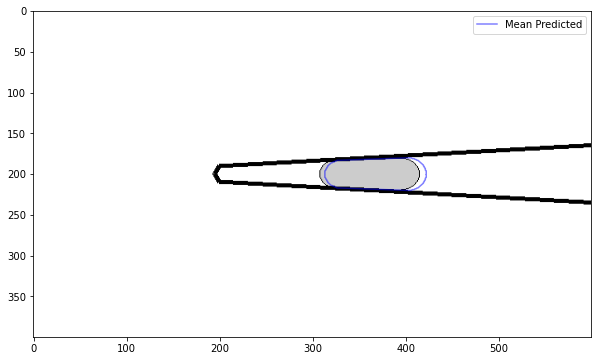

In [157]:
plot_mean_shape(x_experiments, y_experiments, flat_samples, r_idx=7)

## Plot the G, K and p_walls from our chains and overlay with MLE estimate

In [50]:
def visualise_samples(flat_chain, inputs, obs , r_idx=1, num_samples=500, figsize=(20,12)):
    plt.figure(figsize=figsize)
    cap_object = CapillaryImage(
            theta=alpha, l_band=obs[r_idx,1], r_band=obs[r_idx,0], img_size=(600, 400), 
            taper_cutoff=200, is_deg=False, fill_alpha_inner=0.8, fill_alpha_outer=0)
    predicted_l_r_bands = np.array([model(*sample, *inputs[r_idx,:]) for sample in flat_chain])
    temp_image = Image.new(mode="L", size=cap_object.dim, color=255)
    cap_object.generate_image(temp_image, is_annotate=False)
    num_rows_samples = len(predicted_l_r_bands)
    rand_idxs = np.random.choice(num_rows_samples, size=500, replace=False)
    for idx, sample in enumerate(predicted_l_r_bands[rand_idxs,:]):
        try:
            _x_coords, _y_coords = get_outline(sample[1], sample[0], cap_object)
            if idx == 0:
                plt.plot(_x_coords, _y_coords, alpha=0.01, color='blue', label='Predicted Shape from Samples')
            else:
                plt.plot(_x_coords, _y_coords, alpha=0.01, color='blue')
        except ValueError:
            pass
    mle_l_r_bands = model(G_ml, K_ml, p_wall_ml, *inputs[r_idx ,:])
    _x_coords_mle, _y_coords_mle = get_outline(mle_l_r_bands[1], mle_l_r_bands[0], cap_object)
    plt.plot(_x_coords_mle, _y_coords_mle, alpha=0.5, color='red', label='MLE', ls='--')
    plt.legend()
    plt.imshow(temp_image, cmap="gray", aspect="auto")
    plt.show()

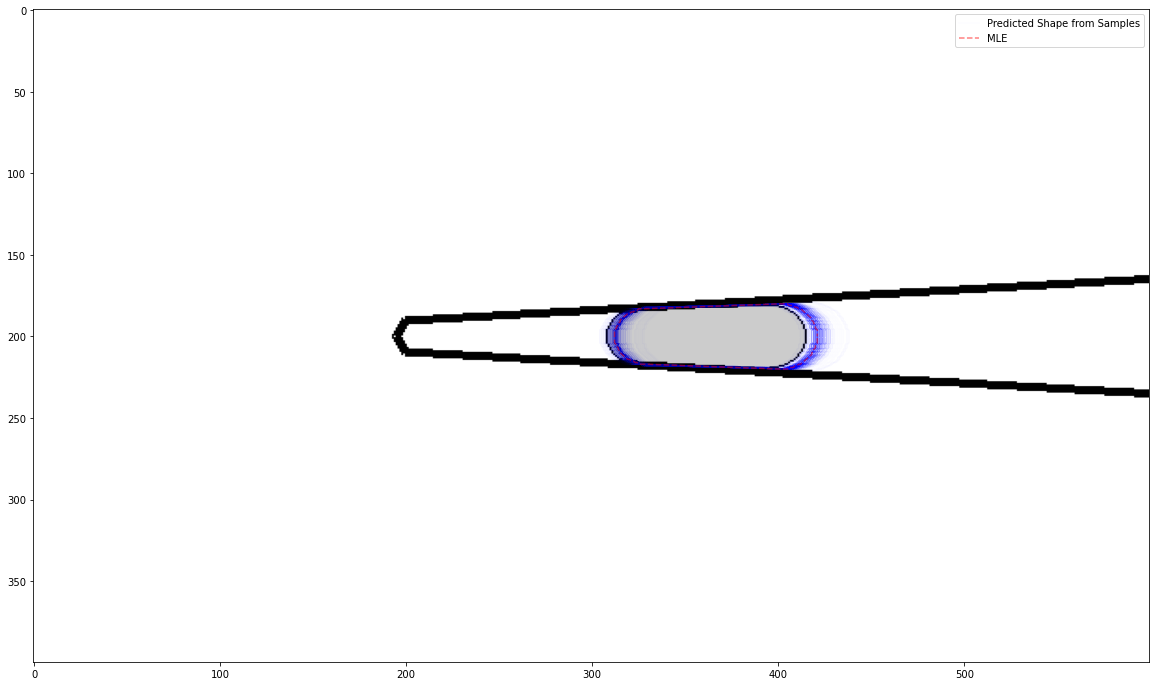

In [158]:
visualise_samples(flat_samples, x_experiments, y_experiments,7)

In [159]:
def plot_samples(flat_chain, inputs, obs ,  ax, r_idx=1, num_samples=500):
    cap_object = CapillaryImage(
            theta=alpha, l_band=obs[r_idx,1], r_band=obs[r_idx,0], img_size=(600, 400), 
            taper_cutoff=200, is_deg=False, fill_alpha_inner=0.8, fill_alpha_outer=0)
    predicted_l_r_bands = np.array([model(*sample, *inputs[r_idx,:]) for sample in flat_samples])
    temp_image = Image.new(mode="L", size=cap_object.dim, color=255)
    cap_object.generate_image(temp_image, is_annotate=False)
    num_rows_samples = len(predicted_l_r_bands)
    rand_idxs = np.random.choice(num_rows_samples, size=500, replace=False)
    for idx, sample in enumerate(predicted_l_r_bands[rand_idxs,:]):
        try:
            _x_coords, _y_coords = get_outline(sample[1], sample[0], cap_object)
            if idx == 0:
                ax.plot(_x_coords, _y_coords, alpha=0.01, color='blue', label='Predicted Shape from Samples')
            else:
                ax.plot(_x_coords, _y_coords, alpha=0.01, color='blue')
        except ValueError:
            pass
    mle_l_r_bands = model(G_ml, K_ml, p_wall_ml, *inputs[r_idx ,:])
    _x_coords_mle, _y_coords_mle = get_outline(mle_l_r_bands[1], mle_l_r_bands[0], cap_object)
    ax.plot(_x_coords_mle, _y_coords_mle, alpha=0.5, color='red', label='MLE', ls='--')
    ax.legend()
    ax.imshow(temp_image, cmap="gray", aspect="auto")

def plot_chain_obs(obs, flat_chain, inputs, figsize=(20, 6)):
    
    nrow = len(obs) // 3 if len(obs) % 3 == 0 else len(obs) // 3 + 1
    fig, axes = plt.subplots(ncols=3, nrows=nrow, figsize=figsize)
    for idx, ob in enumerate(obs):
        plot_samples(flat_chain, inputs, obs, axes.flat[idx], r_idx=idx)
        
    plt.show()

Can see that the model is still very uncertain, with few paramters

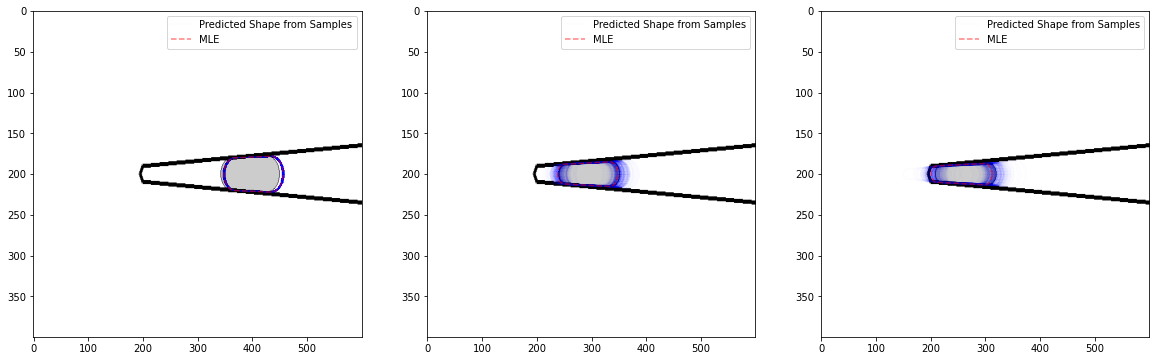

In [161]:
idxs = [1, 15, 24]
plot_chain_obs(y_experiments[idxs,:], flat_samples, x_experiments[idxs,:])

In [54]:
def plot_g_k_uncertainty(inputs, obs, flat_chain, num_samples=300):
    x_rl = inputs[:,:2]
    fig, axes = plt.subplots(ncols=2, figsize=(13, 6))
    eps_rz = (obs - x_rl) / x_rl
    eps_r , eps_z = eps_rz[:,0], eps_rz[:,1]
    rand_idxs = np.random.choice(len(flat_chain), size=num_samples, replace=False)
    flat_chain = flat_chain[rand_idxs, :]
    # plot true G line
    _x_G = np.linspace(0, 2, 10)
    _x_K = np.linspace(0, 0.6, 10)
    exponent = r"$\times 10^2$"
    axes.flat[0].plot(_x_G, _x_G * true_G, ls='--', color='black', label=f'G = {true_G:.3f}{exponent} kPa')
    axes.flat[0].legend()
    axes.flat[1].plot(_x_K, _x_K * true_K, ls='--', color='black', label=f'K = {true_K:.3f}{exponent} kPa')
    axes.flat[1].legend()
    # plot G from our obs
    _p_wall = true_p_factor * inputs[:,2]
    _x_G_obs = np.abs(2 * (eps_r - eps_z))
    _y_G_obs = _p_wall - inputs[:,2]
    axes.flat[0].scatter(_x_G_obs, _y_G_obs, color='red', label=f'Observed')
    # plot K from our obs
    _x_K_obs = np.abs(2 * eps_r + eps_z)
    _y_K_obs = 1/3 * (2* _p_wall + x[:,2])
    axes.flat[1].scatter(_x_K_obs, _y_K_obs, color='red', label=f'Observed')
    # plot G and K from our posterior
    for sample in flat_chain:
        sample_G, sample_K  = sample[0], sample[1]
        axes.flat[0].plot(_x_G, _x_G * sample_G, ls='-', color='blue', alpha=0.01)
        axes.flat[1].plot(_x_K, _x_K * sample_K, ls='-', color='blue', alpha=0.01)


    axes.flat[0].set_xlabel(r'$2(\epsilon_r - \epsilon_z)$')
    axes.flat[0].set_ylabel(f'Min. wall pressure {exponent} kPa')
    axes.flat[1].set_xlabel(r'$2\epsilon_r + \epsilon_z$')
    axes.flat[1].set_ylabel(f'Avg. Pressure {exponent} kPa')


    axes.flat[0].legend()
    axes.flat[1].legend()
    # plt.legend()
    plt.show()

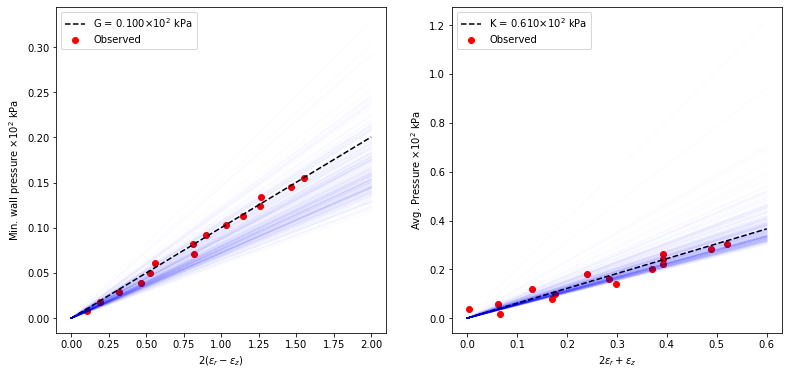

In [55]:
plot_g_k_uncertainty(x, y_noise, flat_samples)

## TODO:

2. Effect of data 
3. Effect of prior
4. Hierarchichal models.
5. Model diagnostics (data diagnostics)